In [1]:
import shutil

import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.datasets import load_breast_cancer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
import numpy as np
from double_cv import DoubleSearchCV
from encoder import TargetEncoder
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier

%config InlineBackend.figure_format='retina'
plt.rcParams["figure.dpi"] = 70

In [2]:
# Number of random trials
NUM_TRIALS = 30

# Load the dataset
X, y = load_breast_cancer(return_X_y=True)
X = pd.DataFrame(X)

categorical_features = [X.columns.get_loc(c) for c in X.select_dtypes(include=object).columns]

In [3]:
# Set up possible values of parameters to optimize over
p_grid = {"clf__C": [1, 10, 100], "clf__gamma": [0.01, 0.1], "pre__category__alpha": [0.3, 0.8]}

In [4]:
pipeline = Pipeline([
    ('pre', ColumnTransformer([
        ('numeric', StandardScaler(), make_column_selector(dtype_include=np.number)),
        ('category', TargetEncoder(alpha=.3), make_column_selector(dtype_include=object))
    ])),
    ('clf', SVC(kernel="rbf"))
])

Average difference of 0.002462 with std. dev. of 0.003707.


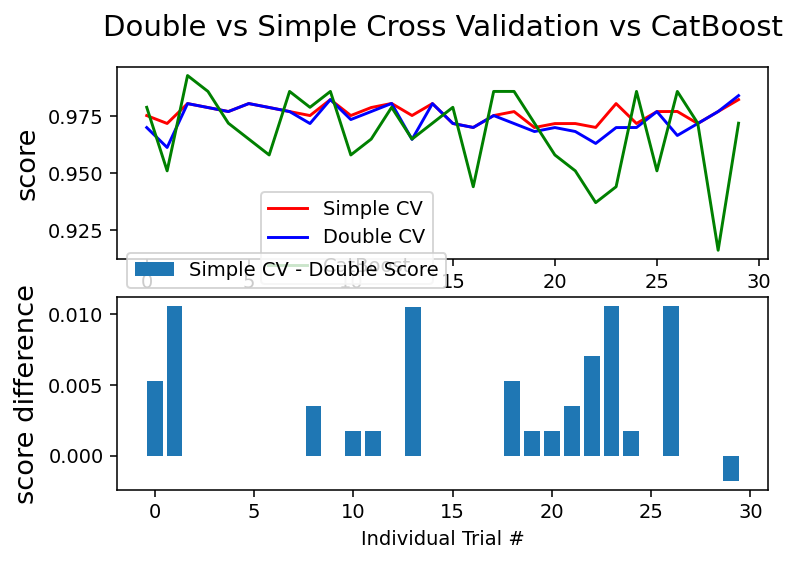

In [5]:
# Arrays to store scores
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)
catboost_scores = np.zeros(NUM_TRIALS)

# Loop for each trial
for i in range(NUM_TRIALS):
    shutil.rmtree('catboost_info', ignore_errors=True)
    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

    # Simple parameter search and scoring
    clf = GridSearchCV(estimator=pipeline, param_grid=p_grid, cv=outer_cv)
    clf.fit(X, y)
    non_nested_scores[i] = clf.best_score_

    # Double CV with parameter optimization
    clf = DoubleSearchCV(estimator=pipeline, param_grid=p_grid, inner_cv=inner_cv, outer_cv=outer_cv)
    clf.fit(X, y)
    nested_scores[i] = clf.best_score_

    X_train, X_test, y_train, y_test = train_test_split(X, y)
    # CatBoost
    clf = Pipeline([
        ('pre', ColumnTransformer([
            ('numeric', StandardScaler(), make_column_selector(dtype_include=np.number)),
        ], remainder='passthrough')),
        ('clf', CatBoostClassifier(iterations=300, silent=True))
    ])
    clf.fit(X_train, y_train)
    catboost_scores[i] = clf.score(X_test, y_test)


score_difference = non_nested_scores - nested_scores

print(
    "Average difference of {:6f} with std. dev. of {:6f}.".format(
        score_difference.mean(), score_difference.std()
    )
)

# Plot scores on each trial for nested and non-nested CV
plt.figure()
plt.subplot(211)
(non_nested_scores_line,) = plt.plot(non_nested_scores, color="r")
(nested_line,) = plt.plot(nested_scores, color="b")
(catboost_line,) = plt.plot(catboost_scores, color="g")
plt.ylabel("score", fontsize="14")
plt.legend(
    [non_nested_scores_line, nested_line, catboost_line],
    ["Simple CV", "Double CV", "CatBoost"],
    bbox_to_anchor=(0, 0.4, 0.5, 0),
)
plt.title(
    "Double vs Simple Cross Validation vs CatBoost",
    x=0.5,
    y=1.1,
    fontsize="15",
)

# Plot bar chart of the difference.
plt.subplot(212)
difference_plot = plt.bar(range(NUM_TRIALS), score_difference)
plt.xlabel("Individual Trial #")
plt.legend(
    [difference_plot],
    ["Simple CV - Double Score"],
    bbox_to_anchor=(0, 1, 0.8, 0),
)
plt.ylabel("score difference", fontsize="14")

plt.show()